# MNIST Handwritten Digit Classification using CNN


In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.datasets import mnist

<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


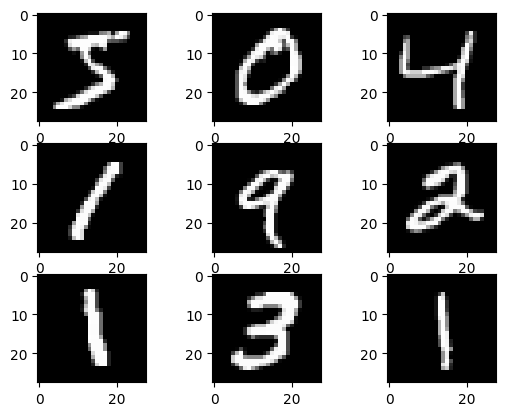

In [28]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

We can see that there are 60,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 28×28 pixels.

<a id="2"></a>
## Normalization, Reshape and Label Encoding
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28)
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel.
* Label Encoding  
    * Encode labels to one hot vectors
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [29]:
# Normalize the data
trainX = trainX / 255.0
testX = testX / 255.0
print("trainX shape: ",trainX.shape)
print("test shape: ",testX.shape)

trainX shape:  (60000, 28, 28)
test shape:  (10000, 28, 28)


In [30]:
# Reshape
trainX = trainX.reshape(-1,28,28,1)
testX = testX.reshape(-1,28,28,1)
print("trainX shape: ",trainX.shape)
print("test shape: ",testX.shape)

trainX shape:  (60000, 28, 28, 1)
test shape:  (10000, 28, 28, 1)


In [31]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
trainy = to_categorical(trainy, num_classes = 10)
testy = to_categorical(testy, num_classes = 10)

In [32]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
trainX, train_val, trainy, valy = train_test_split(trainX, trainy, test_size = 0.1, random_state=2)

In [33]:
trainX.shape

(54000, 28, 28, 1)

<a id="4"></a>
## Convolutional Neural Network
* CNN is used for image classification, object detection
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

<a id="5"></a>
### What is Convolution Operation?
* We have some image and feature detector(3*3)
* Feature detector does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* Feature detector = kernel = filter
* Feauture detector detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices.
* feature map = convolved feature
* Stride = navigating in input image.
* We reduce the size of image. This is important bc code runs faster. However, we lost information.
* We create multiple feature maps bc we use multiple feature detectors(filters).
* Lets look at gimp. Edge detect: [0,10,0],[10,-4,10],[0,10,0]
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>
* After having convolution layer we use ReLU to break up linearity. Increase nonlinearity. Because images are non linear.
* <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

<a id="6"></a>
### Same Padding
* As we keep applying conv layers, the size of the volume will decrease faster than we would like. In the early layers of our network, we want to preserve as much information about the original input volume so that we can extract those low level features.
* input size and output size are same.
* <a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>

<a id="7"></a>
### Max Pooling
* It makes down-sampling or sub-sampling (Reduces the number of parameters)
* It makes the detection of features invariant to scale or orientation changes.
* It reduce the amount of parameters and computation in the network, and hence to also control overfitting.
* <a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>

<a id="8"></a>
### Flattening
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>

<a id="9"></a>
### Full Connection
* Neurons in a fully connected layer have connections to all activations in the previous layer
* Artificial Neural Network
* <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

<a id="10"></a>
## Implementing with Keras

<a id="11"></a>
### Create Model
* conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)
* Dropout: Dropout is a technique where randomly selected neurons are ignored during training
* <a href="https://ibb.co/jGcvVU"><img src="https://preview.ibb.co/e7yPPp/dropout.jpg" alt="dropout" border="0"></a>

In [34]:
#
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

<a id="12"></a>
### Define Optimizer   
* Adam optimizer: Change the learning rate


In [35]:
# Define the optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

<a id="13"></a>
### Compile Model
* categorical crossentropy
* We make binary cross entropy at previous parts and in machine learning tutorial
* At this time we use categorical crossentropy. That means that we have multi class.
* <a href="https://ibb.co/jm1bpp"><img src="https://preview.ibb.co/nN3ZaU/cce.jpg" alt="cce" border="0"></a>


In [36]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<a id="14"></a>
### Epochs and Batch Size
* Say you have a dataset of 10 examples (or samples). You have a **batch size** of 2, and you've specified you want the algorithm to run for 3 **epochs**. Therefore, in each epoch, you have 5 **batches** (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations **per epoch**.
* reference: https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [37]:
epochs = 10  # for better result increase the epochs
batch_size = 250

<a id="15"></a>
### Data Augmentation
* To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
* Alter the training data with small transformations to reproduce the variations of digit.
* For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.
* <a href="https://ibb.co/k24CUp"><img src="https://preview.ibb.co/nMxXUp/augment.jpg" alt="augment" border="0"></a>
    


In [38]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(trainX)

<a id="16"></a>
### Fit the model

In [39]:
# Fit the model
history = model.fit(datagen.flow(trainX,trainy, batch_size=batch_size),
                              epochs = epochs, validation_data = (train_val,valy), steps_per_epoch=trainX.shape[0] // batch_size)

Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.5098 - loss: 1.4237 - val_accuracy: 0.9507 - val_loss: 0.1759
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9507 - val_loss: 0.1759
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.8728 - loss: 0.4005 - val_accuracy: 0.9705 - val_loss: 0.1050
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9705 - val_loss: 0.1050
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.9101 - loss: 0.2858 - val_accuracy: 0.9747 - val_loss: 0.0816
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9747 - val_loss: 0.0816
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9259 - loss: 0.2366 - val_accuracy: 0.9795 - val_loss: 0.0702
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+

<a id="17"></a>
### Evaluate the model
* Test Loss visualization
* Confusion matrix


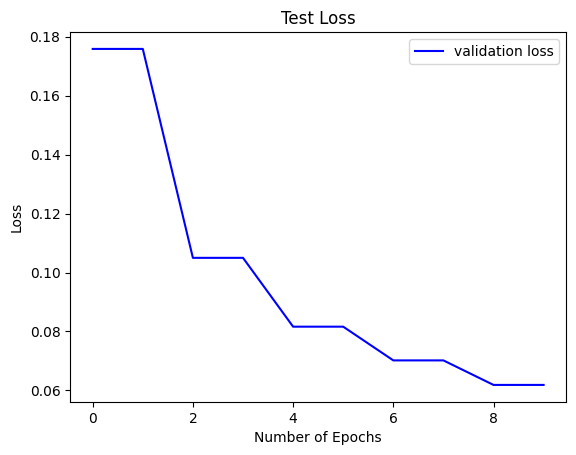

In [40]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


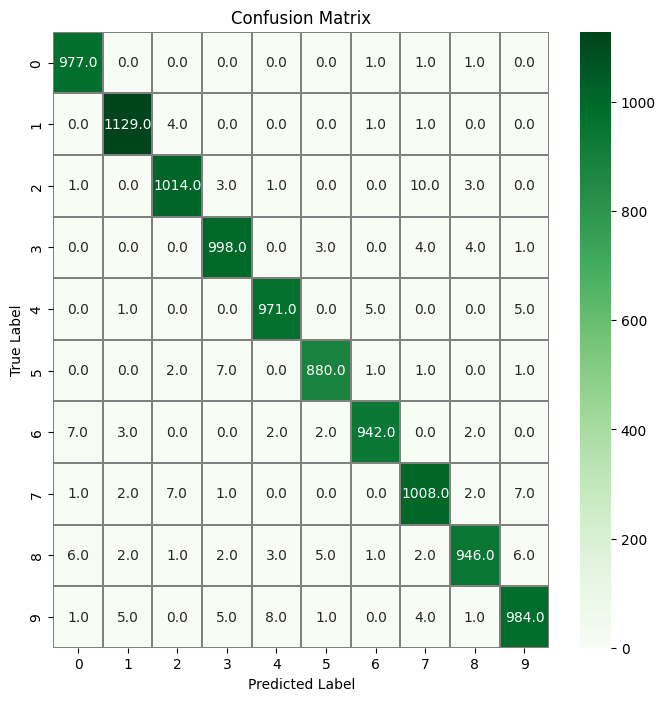

In [41]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(testX)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(testy,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [42]:
### calculate accuracy on test data
from sklearn.metrics import accuracy_score
accuracy_score(Y_true, Y_pred_classes)

0.9849

In [43]:
import tensorflow as tf
print(tf.__version__)

2.17.1
